## 3.16 实战Kaggle比赛：房价预测

### 3.16.1 Kaggle比赛

[房价预测比赛地址](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

### 3.16.2 获取和读取数据集

In [1]:
import pandas as pd
import keras
import keras.backend as K
from livelossplot.keras import PlotLossesCallback

Using TensorFlow backend.


In [2]:
train_data = pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('../data/house-prices-advanced-regression-techniques/test.csv')

In [3]:
print(train_data.shape, test_data.shape)
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]


(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [4]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

### 3.16.3 预处理数据

In [5]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [6]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [7]:
n_train = train_data.shape[0]
train_features = all_features[:n_train].values
test_features = all_features[n_train:].values
train_labels = train_data.SalePrice.values.reshape((-1, 1))

print(train_features)
print(train_labels)

[[ 0.06731988 -0.18444262 -0.21784137 ...  1.          0.
   0.        ]
 [-0.87346638  0.45809588 -0.07203174 ...  1.          0.
   0.        ]
 [ 0.06731988 -0.05593492  0.13717338 ...  1.          0.
   0.        ]
 ...
 [ 0.30251644 -0.14160672 -0.14278111 ...  1.          0.
   0.        ]
 [-0.87346638 -0.05593492 -0.0571972  ...  1.          0.
   0.        ]
 [-0.87346638  0.24391638 -0.02930318 ...  1.          0.
   0.        ]]
[[208500]
 [181500]
 [223500]
 ...
 [266500]
 [142125]
 [147500]]


### 3.16.4 训练模型

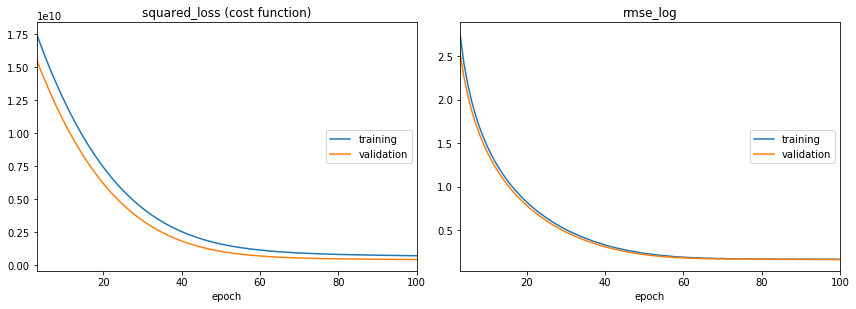

squared_loss (cost function):
training   (min: 698765665.680, max: 19272129391.050, cur: 698765665.680)
validation (min: 412260488.329, max: 17203035430.575, cur: 412260488.329)

rmse_log:
training   (min:    0.162, max:    5.249, cur:    0.162)
validation (min:    0.160, max:    3.635, cur:    0.160)


In [8]:
model = keras.Sequential()
#model.add(keras.layers.Dense(32))
model.add(keras.layers.Dense(1))

def squared_loss(y_true, y_pred):
    return K.square(y_pred - y_true) / 2

def rmse_log(y_true, y_pred):
    log_true = K.log(K.clip(y_true, K.epsilon(), None))
    log_pred = K.log(K.clip(y_pred, K.epsilon(), None))
    return K.sqrt(K.mean(K.square(log_true - log_pred)))

model.compile(
    loss=squared_loss, 
    optimizer=keras.optimizers.Adam(lr=5), metrics=[rmse_log])

model.fit(train_features, train_labels, 
          epochs=100, batch_size=64, validation_split=0.1,
          verbose=1, callbacks=[PlotLossesCallback()])

### 3.16.5 K折线验证
(pass)
### 3.16.6 模型选择

### 3.16.7 预测并在Kaggle提交结果

In [9]:
test_labels = model.predict(test_features)
test_data['SalePrice'] = pd.Series(test_labels.reshape(1, -1)[0])
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv('../data/house-prices-advanced-regression-techniques/submission.csv', index=False)